# Разработка модели предсказания потери почтовых отправлений

In [50]:
# Таблицы и вычисления
import pandas as pd
import numpy as np

# Подготовка данных
from sklearn.preprocessing import power_transform
import texthero as hero
from sklearn.decomposition import PCA
from lightautoml.reader.base import PandasToPandasReader

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Модели и автоматизация
import tensorflow as tf
from tensorflow import keras
from lightautoml.ml_algo.boost_lgbm import BoostLGBM

from lightautoml.pipelines.ml.base import MLPipeline
from lightautoml.pipelines.features.lgb_pipeline import LGBSimpleFeatures
from lightautoml.pipelines.selection.importance_based import (
    ImportanceCutoffSelector, 
    ModelBasedImportanceEstimator
)

from lightautoml.ml_algo.tuning.optuna import OptunaTuner

from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from lightautoml.automl.base import AutoML

# Метрики качества
from sklearn.metrics import recall_score, roc_auc_score, f1_score

# Отчеты
from lightautoml.report.report_deco import ReportDeco
import logging

print("TfVersion:", tf.__version__)

TfVersion: 2.10.0


In [2]:
SEED=202211

## Dataset

In [12]:
train_df = pd.read_csv(
    filepath_or_buffer="Data/train_dataset_train.csv",
    dtype={
        "id": "int32",
        "oper_type + oper_attr": "str",            # Тип и атрибут операции
        "index_oper": "str",                       # Индекс (почтовый) места операции, TODO: очистить данные
        "type": "str",                             # Обозначение типа объекта почтовой связи (20 кат, вкл. 0)
        "priority": "int32",                       # Приоритет объекта (0, 7503, 7504, 7506)        
        "is_privatecategory": "str",               # Является отделением закрытого типа (Y, N)
        "class": "int32",                          # Значение класса или категории объекта почтовой связи (0-5)
        "is_in_yandex": "str",                     # Адрес отделения связи отображается в Яндекс-картах (Y, N)
        "is_return": "str",                        # Отправление движется в направлении возврата (Y, N)
        "weight": "int32",                         # Вес в граммах (округление до грамма, выбросы, проверить)
        "mailtype": "int32",                       # Код вида отправления (0-9)
        "mailctg": "str",                          # Код категории почтового отправления (-1-5, 5 кат.)
        "mailrank": "int32",                       # Код разряда почтового отправления (0) TODO: - drop col
        "directctg": "int32",                      # Код классификации отправления (0-2, 3 кат.)
        "transport_pay": "float",                  # Общая сумма платы за пересылку в условной валюте (max=830.5)
        "postmark": "int32",                       # Код отметки (Основной=0, 1, 8, 256, 512, 1024)
        "name_mfi": "str",                         # Наименование вложений на бирке отправления (высокая кардинальность)
        "weight_mfi": "int32",                     # Суммарная масса вложений - граммы (выбросы, проверить)
        "price_mfi": "int32",                      # Суммарная стоимость вложений в условной валюте
        "dist_qty_oper_login_1": "int32",          # К-во уник. имен операторов, при обработке mailtype
        "total_qty_oper_login_1": "int32",         # К-во отправлений с уник. именем операторов, при обработке mailtype
        "total_qty_oper_login_0": "int32",         # К-во отправлений mailtype, обработаны оператором на индексе
        "total_qty_over_index_and_type": "int32",  # Общее к-во отправлений mailtype, обработанных на этом индексе
        "total_qty_over_index": "int32",           # Общее к-во отправлений, прошедших обработку на этом индексе
        "is_wrong_sndr_name": "int32",             # Имя отправителя введено некорректно (1, 0)
        "is_wrong_rcpn_name": "int32",             # Имя получателя введено некорректно (1, 0)
        "is_wrong_phone_number": "int32",          # Номер телефона получателя введен некорректно (1, 0)
        "is_wrong_address": "int32",               # Адрес получателя введен некорректно (1, 0)
        "label": "int32",                          # Таргет: 1 - цифровой след оборвался, 0 - вручено или возвращено
    },
)

train_df.head(3)

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label
0,6818780,1043_-1,628629,Участок,7503,N,0,Y,N,87,...,42,720176,58950,779126,8290896,0,0,0,0,0
1,9907176,1023_-1,102976,ММПО,7503,N,0,N,N,107,...,914,48856658,83318932,132175590,136819803,0,0,0,0,0
2,3304275,1018_-1,620962,Цех,7503,N,0,Y,N,50,...,62,3246292,3233068,6479360,52708071,0,1,0,0,0


In [4]:
train_df.info(null_counts=True)

C:\Users\Dmitry.Khodykin\AppData\Local\Temp\ipykernel_10368\602459805.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  train_df.info(null_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 29 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   id                             6000000 non-null  int32  
 1   oper_type + oper_attr          6000000 non-null  object 
 2   index_oper                     6000000 non-null  object 
 3   type                           6000000 non-null  object 
 4   priority                       6000000 non-null  int32  
 5   is_privatecategory             6000000 non-null  object 
 6   class                          6000000 non-null  int32  
 7   is_in_yandex                   6000000 non-null  object 
 8   is_return                      6000000 non-null  object 
 9   weight                         6000000 non-null  int32  
 10  mailtype                       6000000 non-null  int32  
 11  mailctg                        6000000 non-null  object 
 12  mailrank      

In [13]:
test_df = pd.read_csv(
    filepath_or_buffer="Data/test_dataset_test.csv",
    dtype={
        "id": "int32",
        "oper_type + oper_attr": "str",
        "index_oper": "str",
        "type": "str",
        "priority": "int32",       
        "is_privatecategory": "str",
        "class": "int32",
        "is_in_yandex": "str",
        "is_return": "str",
        "weight": "int32",
        "mailtype": "int32",
        "mailctg": "str",
        "mailrank": "int32",
        "directctg": "int32",
        "transport_pay": "float",
        "postmark": "int32",
        "name_mfi": "str",
        "weight_mfi": "int32",
        "price_mfi": "int32",
        "dist_qty_oper_login_1": "int32",
        "total_qty_oper_login_1": "int32",
        "total_qty_oper_login_0": "int32",
        "total_qty_over_index_and_type": "int32",
        "total_qty_over_index": "int32",
        "is_wrong_sndr_name": "int32",
        "is_wrong_rcpn_name": "int32",
        "is_wrong_phone_number": "int32",
        "is_wrong_address": "int32",
    },
)

test_df.head(3)

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address
0,7815282,8_13,102976,ММПО,7503,N,0,N,N,85,...,489,972,68766046,91123247,159889293,164927295,0,0,0,0
1,8443555,8_2,238753,ГОПС,7503,N,4,Y,N,21,...,186,2,2895,1545,4440,20623,0,1,1,0
2,6352559,1020_-1,618254,ГОПС,7503,N,4,Y,N,388,...,500,3,2751,993,3744,37817,0,0,0,0


In [6]:
test_df.info(null_counts=True)

C:\Users\Dmitry.Khodykin\AppData\Local\Temp\ipykernel_10368\198631561.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  test_df.info(null_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 28 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   id                             4000000 non-null  int32  
 1   oper_type + oper_attr          4000000 non-null  object 
 2   index_oper                     4000000 non-null  object 
 3   type                           4000000 non-null  object 
 4   priority                       4000000 non-null  int32  
 5   is_privatecategory             4000000 non-null  object 
 6   class                          4000000 non-null  int32  
 7   is_in_yandex                   4000000 non-null  object 
 8   is_return                      4000000 non-null  object 
 9   weight                         4000000 non-null  int32  
 10  mailtype                       4000000 non-null  int32  
 11  mailctg                        4000000 non-null  object 
 12  mailrank      

## EDA + Features Engineering

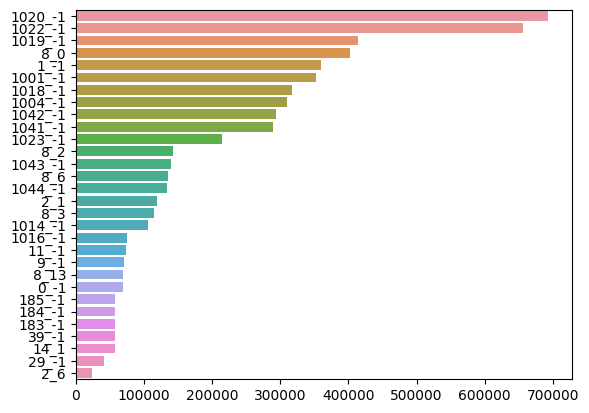

In [97]:
# 1. Тип и атрибут операции: ["oper_type + oper_attr"]           

sns.barplot(
    y=train_df["oper_type + oper_attr"].value_counts()[:30].index, 
    x=train_df["oper_type + oper_attr"].value_counts()[:30].values
);

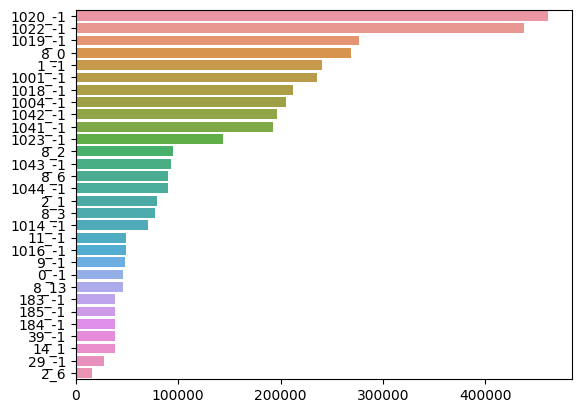

In [98]:
sns.barplot(
    y=test_df["oper_type + oper_attr"].value_counts()[:30].index, 
    x=test_df["oper_type + oper_attr"].value_counts()[:30].values
);

In [37]:
# Кодирование типа и атрибута хэшированным признаком,
# так как мы не знаем полного словаря

N_BUCKETS = 100


def string_to_hash_bucket(col):
    fingerprint = tf.strings.to_hash_bucket_fast(
        col, 
        N_BUCKETS,
    ).numpy()
    return fingerprint


train_df_featured = train_df.copy()
test_df_featured = test_df.copy()

train_df_featured["oper_hash"] = train_df_featured["oper_type + oper_attr"].apply(
    string_to_hash_bucket
)

test_df_featured["oper_hash"] = test_df_featured["oper_type + oper_attr"].apply(
    string_to_hash_bucket
)

train_df_featured = train_df_featured.drop(["oper_type + oper_attr"], axis=1)
test_df_featured = test_df_featured.drop(["oper_type + oper_attr"], axis=1)


In [8]:
train_df_featured.head()

,id,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,mailtype,...,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label,oper_hash
0,6818780,628629,Участок,7503,N,0,Y,N,87,5,...,720176,58950,779126,8290896,0,0,0,0,0,78
1,9907176,102976,ММПО,7503,N,0,N,N,107,5,...,48856658,83318932,132175590,136819803,0,0,0,0,0,80
2,3304275,620962,Цех,7503,N,0,Y,N,50,5,...,3246292,3233068,6479360,52708071,0,1,0,0,0,19
3,9020937,344964,Цех,7503,N,0,Y,N,416,5,...,2060928,653280,2714208,19562334,0,0,0,0,0,5
4,3082311,629819,Участок,7503,N,0,Y,N,795,5,...,316919,27911,344830,4719186,0,0,0,0,0,90


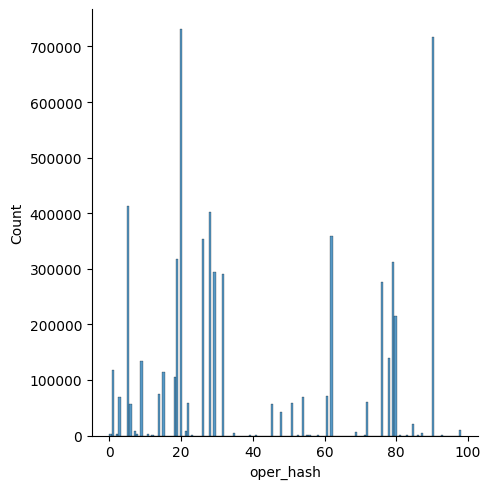

In [9]:
sns.displot(train_df_featured["oper_hash"]);

Количество корзин операций в будущем можно уменьшить для более равномерного распределения.

In [10]:
# 2. index_oper: "str", Индекс (почтовый) места операции, TODO: очистить данные
# Первые три цифры индекса соответствуют определенному субъекту федерации, 
# следующие три — номеру почтового отделения в нём

print(
    "Количество отделений почты:", len(
        train_df_featured["index_oper"].unique()
    )
)

Количество отделений почты: 22159


In [38]:
# Пустые индексы преобразуем

train_df_featured["index_oper"] = train_df_featured["index_oper"].apply(
    lambda x: 900_000 if x == " " else x
)

test_df_featured["index_oper"] = test_df_featured["index_oper"].apply(
    lambda x: 900_000 if x == " " else x
)

train_df_featured["index_oper"] = train_df_featured["index_oper"].astype("float").astype("int32")
test_df_featured["index_oper"] = test_df_featured["index_oper"].astype("float").astype("int32")

train_df_featured["index_oper"] = train_df_featured["index_oper"].apply(
    lambda x: 900_000 if x == 0 else x
)

test_df_featured["index_oper"] = test_df_featured["index_oper"].apply(
    lambda x: 900_000 if x == 0 else x
)


In [39]:
train_df_featured["index_oper"] = train_df_featured["index_oper"].astype("str").apply(lambda x: x[:3])
test_df_featured["index_oper"] = test_df_featured["index_oper"].astype("str").apply(lambda x: x[:3])

In [40]:
print(
    "Количество отделений почты:", len(
        train_df_featured["index_oper"].unique()
    )
)

Количество отделений почты: 236


In [14]:
train_df_featured.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int32  
 1   index_oper                     object 
 2   type                           object 
 3   priority                       int32  
 4   is_privatecategory             object 
 5   class                          int32  
 6   is_in_yandex                   object 
 7   is_return                      object 
 8   weight                         int32  
 9   mailtype                       int32  
 10  mailctg                        object 
 11  mailrank                       int32  
 12  directctg                      int32  
 13  transport_pay                  float64
 14  postmark                       int32  
 15  name_mfi                       object 
 16  weight_mfi                     int32  
 17  price_mfi                      int32  
 18  di

In [41]:
%timeit

N_COMP = 10

pca = PCA(n_components=N_COMP, random_state=SEED)
index_oper_pca_train = pca.fit_transform(
    pd.get_dummies(train_df_featured["index_oper"])
)
index_oper_pca_test = pca.transform(
    pd.get_dummies(test_df_featured["index_oper"])
)


In [43]:
print(
    "index pca train:", index_oper_pca_train.shape, "\n",
    "index pca test:", index_oper_pca_test.shape
)

index pca train: (6000000, 10) 
 index pca test: (4000000, 10)


In [42]:
pca_col = 0
for i in range(N_COMP):
    train_df_featured[f"index_pca_{pca_col}"] = index_oper_pca_train[:, 0+pca_col:1+pca_col]
    test_df_featured[f"index_pca_{pca_col}"] = index_oper_pca_test[:, 0+pca_col:1+pca_col]
    pca_col = pca_col + 1

In [46]:
train_df_featured.head()

,id,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,mailtype,...,index_pca_0,index_pca_1,index_pca_2,index_pca_3,index_pca_4,index_pca_5,index_pca_6,index_pca_7,index_pca_8,index_pca_9
0,6818780,628,Участок,7503,N,0,Y,N,87,5,...,0.493064,-0.005066,0.013730,0.069485,-0.075842,-0.075738,-0.024413,-0.087494,-0.015022,-0.009378
1,9907176,102,ММПО,7503,N,0,N,N,107,5,...,-0.505238,0.000291,-0.000764,-0.003335,0.002861,0.002139,0.000484,0.001473,0.000174,0.000099
2,3304275,620,Цех,7503,N,0,Y,N,50,5,...,0.552884,0.779414,-0.348350,-0.354971,0.149827,0.076229,0.013428,0.037953,0.003742,0.002086
3,9020937,344,Цех,7503,N,0,Y,N,416,5,...,0.492901,-0.005050,0.013686,0.069233,-0.075491,-0.075269,-0.024376,-0.086488,-0.018081,-0.010051
4,3082311,629,Участок,7503,N,0,Y,N,795,5,...,0.486400,-0.004493,0.012133,0.060349,-0.063693,-0.060460,-0.018048,-0.061636,-0.010986,-0.006453


10X_XXX - почтовые индексы Москвы. Все грузы, судя по распределению, проходят через почтовые отделения МСК.

In [53]:
# Поскольку индекс почты, признак категориальный, также захэшируем его

N_BUCKETS = 10


def string_to_hash_bucket(col):
    fingerprint = tf.strings.to_hash_bucket_fast(
        col, 
        N_BUCKETS,
    ).numpy()
    return fingerprint


train_df_featured["index_oper"] = train_df_featured["index_oper"].astype("str")
test_df_featured["index_oper"] =  test_df_featured["index_oper"].astype("str")

train_df_featured["hashed_index"] = train_df_featured["index_oper"].apply(
    string_to_hash_bucket
)

test_df_featured["hashed_index"] = test_df_featured["index_oper"].apply(
    string_to_hash_bucket
)

In [54]:
train_df_featured["index_oper"] = train_df_featured["index_oper"].astype("int32")
test_df_featured["index_oper"] =  test_df_featured["index_oper"].astype("int32")

In [149]:
# train_df_featured["index_oper"] = train_df_featured["index_oper"].astype("int32")
# test_df_featured["index_oper"] = test_df_featured["index_oper"].astype("int32")

# train_df_featured["index_oper"] = train_df_featured["index_oper"].apply(lambda x: 900_000 if x == 0 else x)
# test_df_featured["index_oper"] = test_df_featured["index_oper"].apply(lambda x: 900_000 if x == 0 else x)

In [153]:
# Параметрическое, монотонное преобразование, позволяющее сделать данные более гауссоподобными

# train_df_featured["index_oper_boxed"], est_lambda = (
#     scipy.stats.boxcox(train_df_featured["index_oper"])
# )

# test_df_featured["index_oper_boxed"] = scipy.stats.boxcox(
#     test_df_featured["index_oper"], est_lambda
# )

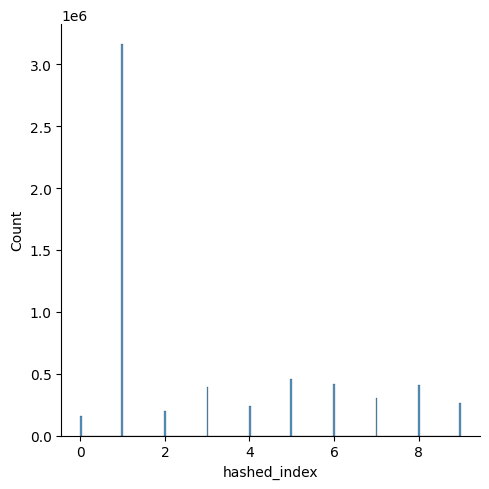

In [55]:
sns.displot(train_df_featured["hashed_index"]);

In [177]:
# "name_mfi": "str", Наименование вложений на бирке отправления (высокая кардинальность)

In [56]:
# Очистим текст
train_df_featured["name_mfi_cleaned"] = hero.clean(train_df_featured["name_mfi"])
test_df_featured["name_mfi_cleaned"] = hero.clean(test_df_featured["name_mfi"])

In [57]:
# Создадим векторы из текста

VEC_LEN = 10

def vectorize_layer(
    input_data,
    vocab_size=5_000,
    max_len=VEC_LEN,
):
    vectorizer = keras.layers.experimental.preprocessing.TextVectorization(
        max_tokens=vocab_size,
        standardize='lower_and_strip_punctuation',
        split='whitespace',
        output_sequence_length=max_len,
        output_mode='int',
    )
    text_dataset = tf.data.Dataset.from_tensor_slices(
        [txt for txt in train_df["name_mfi"]]
    )
    vectorizer.adapt(text_dataset.batch(64))
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
    model.add(vectorizer)
    
    _data = [[input_data]]
     
    return model.predict(_data)

In [58]:
train_vectorized_mfi = vectorize_layer(train_df_featured["name_mfi_cleaned"])
test_vectorized_mfi = vectorize_layer(test_df_featured["name_mfi_cleaned"])

125000/125000 [==============================] - 51110s 409ms/step


In [59]:
# Преобразуем матрицу в столбцы датафрейма

print(
    "train_vector shape:", train_vectorized_mfi.shape, "\n",
    "test_vector shape:", test_vectorized_mfi.shape,
)

train_vector shape: (6000000, 10) 
 test_vector shape: (4000000, 10)


In [60]:
train_vectorized_mfi

array([[4116,   41,    0, ...,    0,    0,    0],
       [   8,   24,    5, ...,    0,    0,    0],
       [ 184,  236,   70, ...,    0,    0,    0],
       ...,
       [ 316,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [  26,   58,   26, ...,    0,    0,    0]], dtype=int64)

In [61]:
vec_col = 0
train_vectorized_mfi[:, 0+vec_col:1+vec_col]

array([[4116],
       [   8],
       [ 184],
       ...,
       [ 316],
       [   0],
       [  26]], dtype=int64)

In [62]:
vec_col = 0
for i in range(VEC_LEN):
    train_df_featured[f"embed_txt_{vec_col}"] = train_vectorized_mfi[:, 0+vec_col:1+vec_col]
    test_df_featured[f"embed_txt_{vec_col}"] = test_vectorized_mfi[:, 0+vec_col:1+vec_col]
    vec_col = vec_col + 1

In [72]:
train_df_featured["type"].value_counts()

Цех               2093668
ММПО              1614974
Участок            926631
ГОПС               463750
ТИ                 305490
П                  245814
МСЦ                223241
СОПС                72161
СЦ                  12469
ОП                   9527
МСО                  7465
ОПП                  7190
АОПП                 6682
МРП                  3850
0                    3444
АО                   1304
ПЕРЕДВИЖНОЕ ОС       1006
ППС                   682
УМСЦ                  569
УКД                    83
Name: type, dtype: int64

In [65]:
# "type": "str", Обозначение типа объекта почтовой связи (20 кат, вкл. 0)

train_type_arr = pd.get_dummies(train_df_featured["type"])
test_type_arr = pd.get_dummies(test_df_featured["type"])

print(
    "train_type_arr shape:", train_type_arr.shape, "\n",
    "test_type_arr shape:", test_type_arr.shape,
)

train_type_arr shape: (6000000, 20) 
 test_type_arr shape: (4000000, 20)


In [66]:
train_type_arr.columns

Index(['0', 'АО', 'АОПП', 'ГОПС', 'ММПО', 'МРП', 'МСО', 'МСЦ', 'ОП', 'ОПП',
       'П', 'ПЕРЕДВИЖНОЕ ОС', 'ППС', 'СОПС', 'СЦ', 'ТИ', 'УКД', 'УМСЦ',
       'Участок', 'Цех'],
      dtype='object')

In [67]:
test_type_arr.columns

Index(['0', 'АО', 'АОПП', 'ГОПС', 'ММПО', 'МРП', 'МСО', 'МСЦ', 'ОП', 'ОПП',
       'П', 'ПЕРЕДВИЖНОЕ ОС', 'ППС', 'СОПС', 'СЦ', 'ТИ', 'УКД', 'УМСЦ',
       'Участок', 'Цех'],
      dtype='object')

In [77]:
train_type_arr["ГОПС"].value_counts()

0    5536250
1     463750
Name: ГОПС, dtype: int64

In [78]:
for col_type in train_type_arr.columns:
    train_df_featured[col_type] = train_type_arr[col_type]
    test_df_featured[col_type] = test_type_arr[col_type]

In [79]:
train_df_featured.columns

Index(['id', 'index_oper', 'type', 'priority', 'is_privatecategory', 'class',
       'is_in_yandex', 'is_return', 'weight', 'mailtype', 'mailctg',
       'directctg', 'transport_pay', 'postmark', 'name_mfi', 'weight_mfi',
       'price_mfi', 'dist_qty_oper_login_1', 'total_qty_oper_login_1',
       'total_qty_oper_login_0', 'total_qty_over_index_and_type',
       'total_qty_over_index', 'is_wrong_sndr_name', 'is_wrong_rcpn_name',
       'is_wrong_phone_number', 'is_wrong_address', 'label', 'oper_hash',
       'index_pca_0', 'index_pca_1', 'index_pca_2', 'index_pca_3',
       'index_pca_4', 'index_pca_5', 'index_pca_6', 'index_pca_7',
       'index_pca_8', 'index_pca_9', 'hashed_index', 'name_mfi_cleaned',
       'embed_txt_0', 'embed_txt_1', 'embed_txt_2', 'embed_txt_3',
       'embed_txt_4', 'embed_txt_5', 'embed_txt_6', 'embed_txt_7',
       'embed_txt_8', 'embed_txt_9', '0', 'АО', 'АОПП', 'ГОПС', 'ММПО', 'МРП',
       'МСО', 'МСЦ', 'ОП', 'ОПП', 'П', 'ПЕРЕДВИЖНОЕ ОС', 'ППС', 'СОПС', 

In [80]:
# "mailctg": "str", Код категории почтового отправления (-1-5, 5 кат.)

train_mailctg_arr = pd.get_dummies(train_df_featured["mailctg"])
test_mailctg_arr = pd.get_dummies(test_df_featured["mailctg"])

print(
    "train_mailctg_arr shape:", train_mailctg_arr.shape, "\n",
    "test_mailctg_arr shape:", test_mailctg_arr.shape,
)

train_mailctg_arr shape: (6000000, 5) 
 test_mailctg_arr shape: (4000000, 5)


In [81]:
train_mailctg_arr.columns

Index(['-1.0', '0.0', '1.0', '3.0', '5.0'], dtype='object')

In [82]:
test_mailctg_arr.columns

Index(['-1.0', '0.0', '1.0', '3.0', '5.0'], dtype='object')

In [83]:
for col_type in train_mailctg_arr.columns:
    train_df_featured[f"mail_cat_{col_type}"] = train_mailctg_arr[col_type]
    test_df_featured[f"mail_cat_{col_type}"] = test_mailctg_arr[col_type]

In [84]:
train_df_featured.columns

Index(['id', 'index_oper', 'type', 'priority', 'is_privatecategory', 'class',
       'is_in_yandex', 'is_return', 'weight', 'mailtype', 'mailctg',
       'directctg', 'transport_pay', 'postmark', 'name_mfi', 'weight_mfi',
       'price_mfi', 'dist_qty_oper_login_1', 'total_qty_oper_login_1',
       'total_qty_oper_login_0', 'total_qty_over_index_and_type',
       'total_qty_over_index', 'is_wrong_sndr_name', 'is_wrong_rcpn_name',
       'is_wrong_phone_number', 'is_wrong_address', 'label', 'oper_hash',
       'index_pca_0', 'index_pca_1', 'index_pca_2', 'index_pca_3',
       'index_pca_4', 'index_pca_5', 'index_pca_6', 'index_pca_7',
       'index_pca_8', 'index_pca_9', 'hashed_index', 'name_mfi_cleaned',
       'embed_txt_0', 'embed_txt_1', 'embed_txt_2', 'embed_txt_3',
       'embed_txt_4', 'embed_txt_5', 'embed_txt_6', 'embed_txt_7',
       'embed_txt_8', 'embed_txt_9', '0', 'АО', 'АОПП', 'ГОПС', 'ММПО', 'МРП',
       'МСО', 'МСЦ', 'ОП', 'ОПП', 'П', 'ПЕРЕДВИЖНОЕ ОС', 'ППС', 'СОПС', 

In [63]:
# mailrank: "int32", Код разряда почтового отправления, только нули. TODO: drop col

train_df_featured = train_df_featured.drop(["mailrank"], axis=1)
test_df_featured = test_df_featured.drop(["mailrank"], axis=1)

In [85]:
train_df_featured.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 75 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int32  
 1   index_oper                     int32  
 2   type                           object 
 3   priority                       int32  
 4   is_privatecategory             object 
 5   class                          int32  
 6   is_in_yandex                   object 
 7   is_return                      object 
 8   weight                         int32  
 9   mailtype                       int32  
 10  mailctg                        object 
 11  directctg                      int32  
 12  transport_pay                  float64
 13  postmark                       int32  
 14  name_mfi                       object 
 15  weight_mfi                     int32  
 16  price_mfi                      int32  
 17  dist_qty_oper_login_1          int32  
 18  to

In [86]:
train_df_featured.to_csv(
    "./Data/train_dataset_featured.csv", 
    index=False, 
    line_terminator="\n",
)

test_df_featured.to_csv(
    "./Data/test_dataset_featured.csv", 
    index=False, 
    line_terminator="\n",
)

print("Featured dataset is saved.")

Featured dataset is saved.


# Featured DF

In [3]:
train_df_featured = pd.read_csv(
    filepath_or_buffer="Data/train_dataset_featured.csv"
)

test_df_featured = pd.read_csv(
    filepath_or_buffer="Data/test_dataset_featured.csv"
)

In [4]:
print(
    train_df_featured.shape, "\n",
    test_df_featured.shape
)

(6000000, 75) 
 (4000000, 74)


In [5]:
TARGET_NAME = "label"

In [9]:
print(
    train_df_featured.shape, "\n",
    test_df_featured.shape
)

(6000000, 141) 
 (4000000, 140)


## Создание и обучение модели

In [52]:
TARGET_NAME = "label"
N_FOLDS = 5
N_JOBS = 8
TRESHOLD = 0.005


task = Task('binary')
reader = PandasToPandasReader(
    task, 
    cv=N_FOLDS, 
    random_state=SEED
)

In [45]:
model0 = BoostLGBM(
    default_params={
        'learning_rate': 0.05, 
        'num_leaves': 64, 
        'seed': SEED, 
        'num_threads': N_JOBS
    }
)

pipe0 = LGBSimpleFeatures()
mbie = ModelBasedImportanceEstimator()

selector = ImportanceCutoffSelector(
    pipe0, 
    model0, 
    mbie, 
    cutoff=0,
)

pipe = LGBSimpleFeatures()

params_tuner1 = OptunaTuner(
    n_trials=20, 
    timeout=30,
)

model1 = BoostLGBM(
    default_params={
        'learning_rate': 0.05, 
        'num_leaves': 128, 
        'seed': 1, 
        'num_threads': N_JOBS,
    }
)

model2 = BoostLGBM(
    default_params={
        'learning_rate': 0.025, 
        'num_leaves': 64, 
        'seed': 2, 
        'num_threads': N_JOBS,
    }
)

pipeline_lvl1 = MLPipeline(
    [
        (model1, params_tuner1),
        model2
    ], 
    pre_selection=selector, 
    features_pipeline=pipe, 
    post_selection=None,
)

pipe1 = LGBSimpleFeatures()

model = BoostLGBM(
    default_params={
        'learning_rate': 0.05, 
        'num_leaves': 64, 
        'max_bin': 1024, 
        'seed': 3, 
        'num_threads': N_JOBS
    },
    freeze_defaults=True
)

pipeline_lvl2 = MLPipeline(
    [model], 
    pre_selection=None, 
    features_pipeline=pipe1, 
    post_selection=None
)

In [49]:
%%time 
automl = AutoML(
    reader, [
        [pipeline_lvl1],
        [pipeline_lvl2],
    ], 
    skip_conn=False
)

CPU times: total: 0 ns
Wall time: 0 ns


In [51]:
oof_pred = automl.fit_predict(
    train_df_featured, 
    roles={'target': TARGET_NAME}
)

logging.info(f'oof_pred:\n{oof_pred}\nShape = {oof_pred.shape}')

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The series.append method is deprecated and will 

In [53]:
%%time
print(f"Predict is run... Treshold: {TRESHOLD}")
test_pred = automl.predict(
    test_df_featured
)
logging.info(f'Prediction for test data:\n{test_pred}\nShape = {test_pred.shape}')
logging.info('Done.')
logging.info(
    f'OOF score: {roc_auc_score(train_df_featured[TARGET_NAME].values, oof_pred.data[:, 0])}'
)
logging.info(
    f'TEST score: {roc_auc_score(test_df_featured[TARGET_NAME].values, test_pred.data[:, 0])}'
)

CPU times: total: 5h 11min 25s
Wall time: 51min 18s


In [54]:
# Подготовка файла к сохранению

y_predicted = (test_pred.data[:, 0] > TRESHOLD)*1
print("Predict is done.")

test_df_featured["label"] = y_predicted

submission = test_df_featured[["id", "label"]]
submission.to_csv(
    "./Out/sample_solution.csv", 
    index=False, 
    line_terminator="\n",
)

print("The submission is saved.")

Predict is run... Treshold: 0.005
Predict is done.
The submission is saved.


## Fit Model with Report & Custom Score

In [17]:
TARGET_NAME = "label"
TASK_NAME = "binary"

N_JOBS = 8
N_FOLDS = 5
SEED = 202211

TRESHOLD = 0.005

In [18]:
def final_score(y_true, y_pred):
    roc_auc = roc_auc_score(y_true, y_pred)
    recall = recall_score(y_true, (y_pred > TRESHOLD)*1)
    score = 0.9 * roc_auc + 0.1 * recall
    return score

In [30]:
RD = ReportDeco(output_path = './Out/Rep/')

automl_rd = RD(
    TabularAutoML(
        task = Task(
            name = TASK_NAME,
            metric = lambda y_true, y_pred: final_score(y_true, y_pred),
        ),
        general_params = {
            "nested_cv": False, 
            "use_algos": [
                [ 
                    "lgb", 
                    "lgb_tuned"
                ]
            ]
        },
        reader_params = {
            "n_jobs": N_JOBS, 
            "cv": N_FOLDS, 
            "random_state": SEED,
        },
    )
)

In [ ]:
oof_pred = automl_rd.fit_predict(
    train_df_featured,
    roles = {"target": TARGET_NAME, "drop": ["id"]},
    verbose=0,
)

In [34]:
print("Used Model:", automl_rd.model.create_model_str_desc())

Used Model: Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_0_Mod_0_LightGBM) 


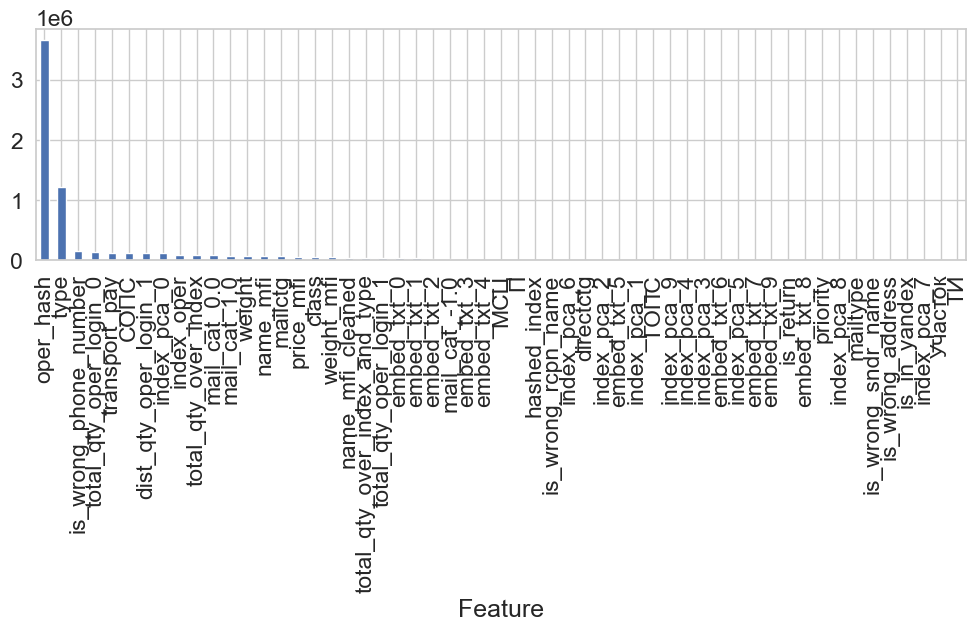

In [33]:
fast_fi = automl_rd.model.get_feature_scores("fast")

fast_fi.set_index("Feature")["Importance"].plot.bar(
    figsize = (12, 3),
    grid = True,
);

In [35]:
# Лучшие признаки

best_features = fast_fi.set_index("Feature")["Importance"][:30].index
print("Best Features:", best_features)

Best Features: Index(['oper_hash', 'type', 'is_wrong_phone_number', 'total_qty_oper_login_0',
       'transport_pay', 'СОПС', 'dist_qty_oper_login_1', 'index_pca_0',
       'index_oper', 'total_qty_over_index', 'mail_cat_0.0', 'mail_cat_1.0',
       'weight', 'name_mfi', 'mailctg', 'price_mfi', 'class', 'weight_mfi',
       'name_mfi_cleaned', 'total_qty_over_index_and_type',
       'total_qty_oper_login_1', 'embed_txt_0', 'embed_txt_1', 'embed_txt_2',
       'mail_cat_-1.0', 'embed_txt_3', 'embed_txt_4', 'МСЦ', 'П',
       'hashed_index'],
      dtype='object', name='Feature')


In [26]:
cols_for_drop = [
    item for item in train_df_featured.drop(
        [TARGET_NAME], 
        axis=1
    ).columns if item not in best_features
]

print(cols_for_drop)

['id', 'priority', 'is_privatecategory', 'is_in_yandex', 'is_return', 'mailtype', 'directctg', 'postmark', 'is_wrong_sndr_name', 'is_wrong_rcpn_name', 'is_wrong_address', 'index_pca_1', 'index_pca_2', 'index_pca_3', 'index_pca_4', 'index_pca_5', 'index_pca_6', 'index_pca_7', 'index_pca_8', 'index_pca_9', 'embed_txt_5', 'embed_txt_6', 'embed_txt_7', 'embed_txt_8', 'embed_txt_9', '0', 'АО', 'АОПП', 'ГОПС', 'ММПО', 'МРП', 'МСО', 'ОП', 'ОПП', 'ПЕРЕДВИЖНОЕ ОС', 'ППС', 'СЦ', 'ТИ', 'УКД', 'УМСЦ', 'Участок', 'Цех', 'mail_cat_3.0', 'mail_cat_5.0']


In [ ]:
# Обучение на лучших признаках

oof_pred = automl_rd.fit_predict(
    train_df_featured,
    roles = {"target": TARGET_NAME, "drop": cols_for_drop},
    verbose=1,
)

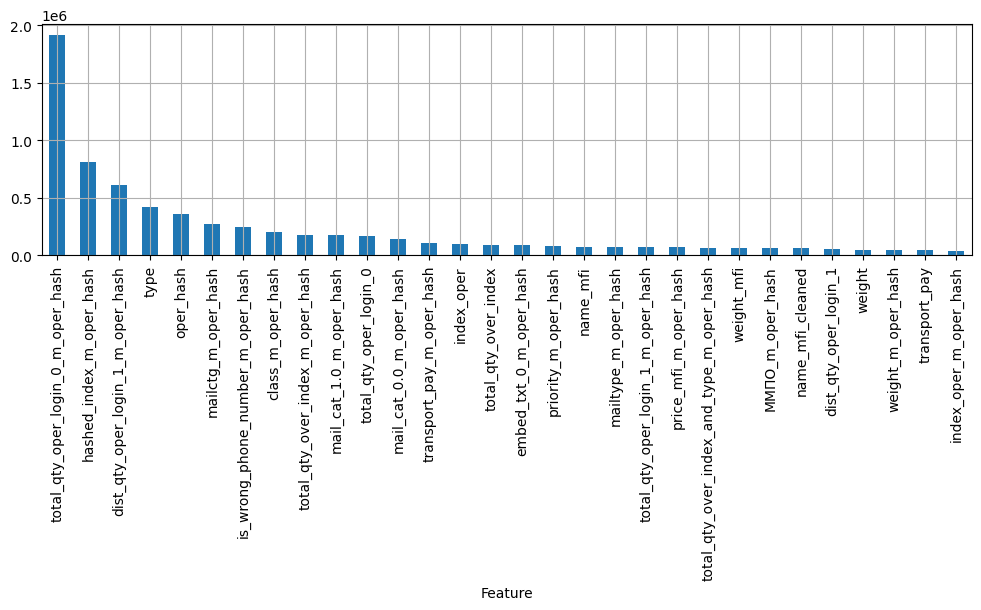

In [21]:
fast_fi = automl_rd.get_feature_scores("fast")

fast_fi.set_index("Feature")["Importance"].plot.bar(
    figsize = (12, 3),
    grid = True,
);

In [36]:
# Предсказание и подготовка файла к сохранению

print(f"Predict is run... Treshold: {TRESHOLD}")
test_pred = automl_rd.predict(test_df_featured)
y_predicted = (test_pred.data[:, 0] > TRESHOLD)*1
print("Predict is done.")

test_df_featured["label"] = y_predicted

submission = test_df_featured[["id", "label"]]
submission.to_csv(
    "./Out/sample_solution.csv", 
    index=False, 
    line_terminator="\n",
)

print("The submission is saved.")

Predict is run... Treshold: 0.005




`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



Predict is done.
The submission is saved.
